In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dataset_summary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [9]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/nbhd_volumes.*pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/nbhd_volumes_l0.pkl',


In [10]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/co

In [11]:
# # fix issues where antibody names aren't consistent accross some images
# channel_to_idents = {
#     'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'PanCK', 'PanCytokeratin'],
#     'E-cadherin': ['E-cadherin', 'E-Cadherin'],
#     'CD45': ['CD45'],
#     'CD45RO': ['CD45RO'],
#     'CD45RA': ['CD45RA'],
#     'CD8': ['CD8', 'CD8a'],
#     'DAPI': ['DAPI'],
#     'CD4': ['CD4'],
#     'CD3e': ['CD3e', 'CD3'],
#     'Vimentin': ['Vimentin', 'Vim', 'VIM'],
#     'SMA': ['SMA', 'a-SMA'],
#     'CD31': ['CD31'],
#     'CD20': ['CD20', 'CD20-Akoya'],
#     'CD68': ['CD68'],
#     'CD163': ['CD163'],
#     'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
#     'cKit': ['cKit', 'cKIT', 'ckit-(D)', 'ckit'],
#     'MGP': ['MGP'],
#     'CD36': ['CD36'],
#     'PR': ['PR'],
#     'ER': ['ER'],
#     'P21': ['P21'],
#     'P16': ['P16'],
#     'CK5': ['Keratin 5', 'KRT5', 'CK5'],
#     'CK7': ['CK7'],
#     'CK8/18': ['CK8/18'],
#     'TFF1': ['TFF1'],
#     'beta-integrin': ['beta-integrin', 'beta3-integrin'],
#     'CK14': ['CK14', 'Keratin 14', 'KRT14'],
#     'CK17': ['CK17', 'Keratin 17', 'CK17'],
#     'CK19': ['CK19', 'Keratin 19', 'KRT19'],
#     'CD11b': ['CD11b', 'CD11B', 'cd11b'],
#     'GATA3': ['GATA3'],
#     'PLAT/tPA': ['PLAT/tPA', 'PLAT'],
#     'COX6c': ['COX6c', 'COX6C (D)', 'COX6C'],
#     'Her2': ['Her2', 'HER2'],
#     'Bap1': ['Bap1', 'BAP1'],
#     'GLUT1': ['Glut1', 'GLUT1'],
#     'CD11c': ['CD11c'],
#     'HLA-DR': ['HLA-DR', 'HLADR'],
#     'Ki67': ['Ki67', 'KI67'],
#     'Podoplanin': ['Podoplanin', 'PDPN'],
#     'CTLA4': ['CTLA4'],
#     'SLC39A6': ['SLC39A6'],
#     'BCA1': ['BCA1'],
#     'BCAL': ['BCAL'],
#     'TUBB3': ['TUBB3'],
#     'PTPRZ1': ['PTPRZ1'],
#     'HIF1A': ['HIF1a', 'HIF1A'],
#     'PAI1': ['PAI1'],
#     'GFAP': ['GFAP'],
#     'VEGFA': ['VEGFA'],
#     'IBA1': ['IBA1'],
#     'OLIG2': ['OLIG2'],
#     'FN1': ['FN1'],
#     'a-Amylase': ['a-Amylase', 'Amylase (D', 'Amylase'],
#     'Hep-Par-1': ['Hep-Par-1', 'HepPar1-(D)', 'HepPar1'],
#     'Granzyme-B': ['Granzyme B', 'GZMB'],
#     'TCF-1': ['TCF-1'],
#     'CD39': ['CD39'],
#     'PD1': ['PD-1', 'PD1'],
#     'PDL1': ['PD-L1', 'PDL1'],
#     'Histone-H3-Pho': ['Histone H3 Pho'],
#     'Maspin': ['Maspin'],
#     'MMP9': ['MMP9'],
#     'CD44': ['CD44'],
#     'CD107A': ['CD107a'],
#     'FGFR3': ['FGFR3'],
#     'CD138': ['CD138'],
#     'MLPH': ['MLPH'],
#     'P63': ['P63', 'p63'],
#     'GP2': ['GP2'],
#     'COX2': ['COX2'],
#     'Lyve-1': ['Lyve-1', 'LYVE1'],
#     'CCL2': ['CCL2'],
#     'MUC2': ['MUC2'],
#     'SOX9': ['SOX9'],
#     'STEAP4': ['STEAP4'],
#     'AR': ['AR'],
#     'AMACR': ['AMACR'],
#     'PGC': ['PGC', 'PGC (D)'],
#     'CFTR': ['CFTR (D)', 'CFTR'],
#     'REG3A': ['REG3A (D)', 'REG3A'],
#     'LAMC2': ['LAMC2 (D)', 'LAMC2'],
#     'INS': ['INS (D)', 'INS'],
#     'CRP': ['CRP (D)', 'CRP'],
#     'CD74': ['CD74 (D)', 'CD74'],
#     'MUC5AC': ['MUC5AC (D)', 'MUC5AC'],
#     'AQP1': ['AQP1'],
#     'AQP2': ['Aqp2', 'AQP2'], 
#     'LRP2': ['LRP2'],
#     'UMOD': ['UMOD'],
#     'CALB1': ['CALB1'],
#     'CP': ['CP'],
#     'CA9': ['CA9'],
#     'UCHL1': ['UCHL1'],
# }
# channel_mapping = {v:k for k, vs in channel_to_idents.items() for v in vs}

# # add in (D) variants
# variants = ['(D)', ' (D)', '(d)', ' (d)', '-(D)', '-(d)', ' (Dnew)', '(Dnew)', '-(Dnew)']
# channel_mapping.update({k + variant:v
#                       for k, v in channel_mapping.items()
#                       for variant in variants})

In [12]:
exclude = ['S18-25943-A7', 'C3L-00970', 'WD-76845']

In [13]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections = {k:v for k, v in case_to_sections.items() if k not in exclude}
case_to_sections.keys()

dict_keys(['C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-5591-C8', 'S18-9906'])

In [14]:
case_meta = pd.read_csv(os.path.join(output_dir, 'case_metadata.txt'), sep='\t')
case_meta = case_meta[[True if x not in exclude else False for x in case_meta['case']]]
case_meta['n_sections'] = [len(case_to_sections[x]) for x in case_meta['case']]
case_to_disease = {k:v for k, v in zip(case_meta['case'], case_meta['tissue_type'])}
    
case_meta

,case,tissue_type,cohort,n_sections
1,C3L-00982,CCRCC,inhouse,5
2,C3L-01287,CCRCC,inhouse,2
3,C3L-02551,CCRCC,inhouse,5
4,HT206B1,BRCA,inhouse,15
5,HT225C1,CRC,inhouse,4
6,HT268B1,BRCA,inhouse,4
7,HT339B2-H1,BRCA,inhouse,2
8,HT397B1,BRCA,inhouse,12
9,HT413C1-K2,CRC,inhouse,2
10,HT413C1-Th1k4A1,CRC,inhouse,28


In [15]:
case_order = case_meta.sort_values(['tissue_type', 'n_sections'])['case'].to_list()
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

HT339B2-H1


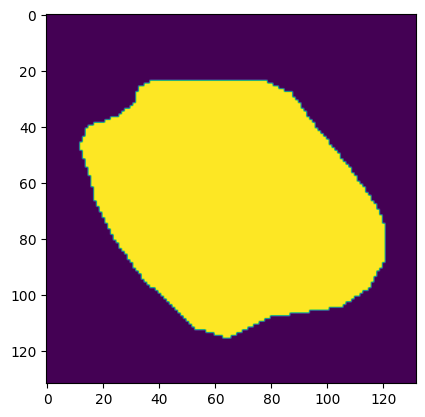

(132, 132) (2, 132, 132)
[(4, 19622, 3880), (3, 280, 0), (2, 234, 3084), (14, 126, 1402), (0, 120, 1956), (5, 86, 0), (13, 52, 672), (1, 50, 764), (11, 38, 1268), (7, 8, 294), (12, 6, 248), (8, 4, 66), (6, 4, 260), (16, 4, 98), (9, 4, 42), (18, 2, 20)]
HT565B1-H2


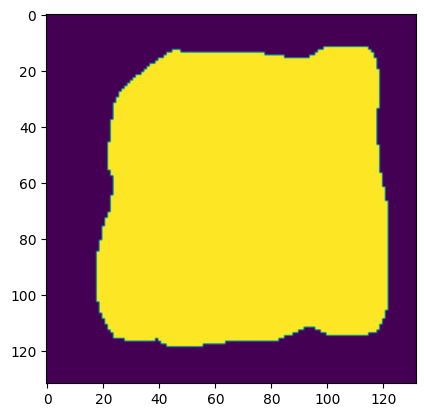

(132, 132) (3, 132, 132)
[(0, 19692, 7200), (4, 2211, 6651), (1, 579, 0)]
HT268B1


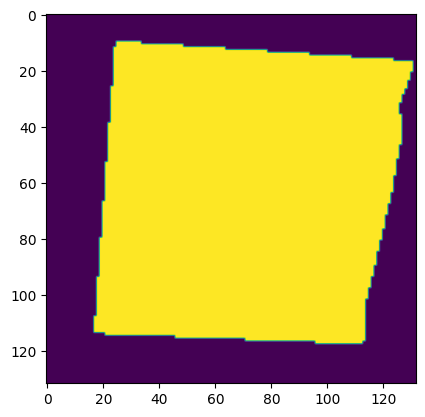

(132, 132) (32, 132, 132)
[(9, 98824, 16573), (5, 55456, 60409), (10, 51360, 1720), (0, 6999, 11083), (8, 5920, 25745), (3, 2085, 20405), (2, 715, 81215), (6, 603, 31021), (1, 333, 9471), (4, 331, 68278), (13, 125, 1506), (11, 48, 6233), (7, 17, 1028)]
HT397B1


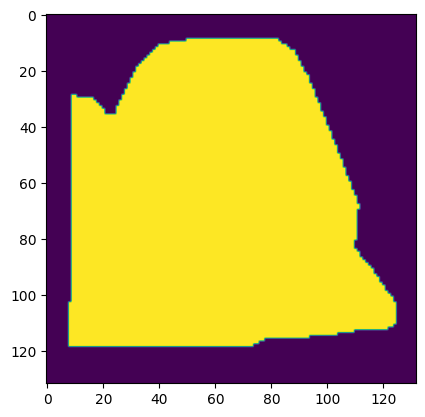

(132, 132) (31, 132, 132)
[(0, 220209, 108689), (15, 2881, 40690), (16, 1569, 17481), (12, 242, 10310), (11, 192, 11198), (1, 183, 8891), (2, 146, 5359), (3, 137, 22110), (8, 121, 943), (7, 105, 13162), (6, 101, 11422), (13, 39, 8304), (10, 34, 8040)]
HT206B1


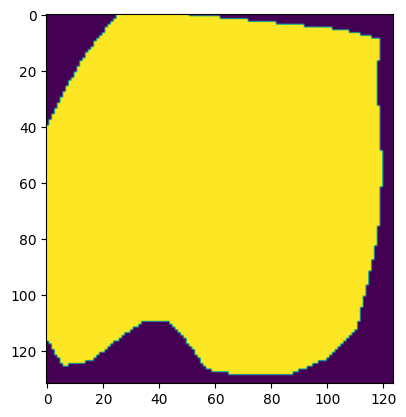

(132, 124) (25, 132, 124)
[(13, 57803, 108014), (15, 13375, 10017), (10, 22, 101822)]
C3L-01287


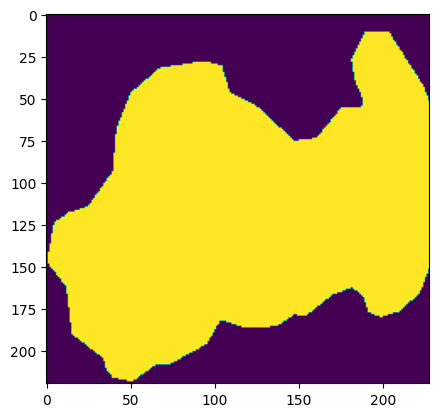

(220, 228) (2, 220, 228)
[(4, 41016, 19318), (10, 4, 2614), (14, 2, 3694)]
C3L-00982


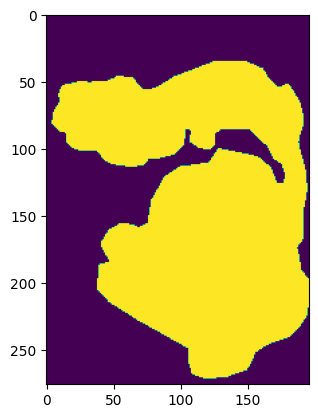

(276, 196) (7, 276, 196)
[(0, 168329, 64531), (33, 8183, 18473), (3, 819, 28650), (32, 511, 9912)]
C3L-02551


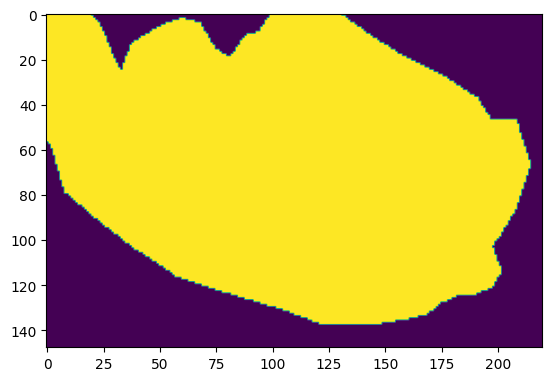

(148, 220) (8, 148, 220)
[(3, 83140, 33730), (10, 4, 176)]
HT413C1-K2


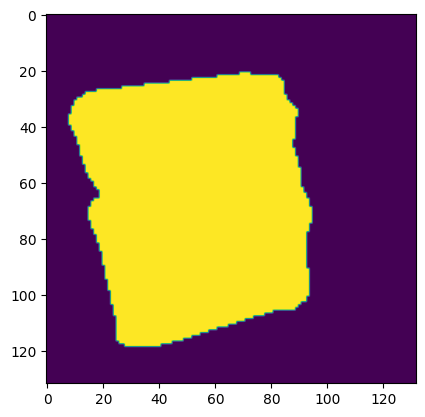

(132, 132) (2, 132, 132)
[(5, 21442, 2196), (12, 82, 0), (13, 44, 0)]
HT225C1


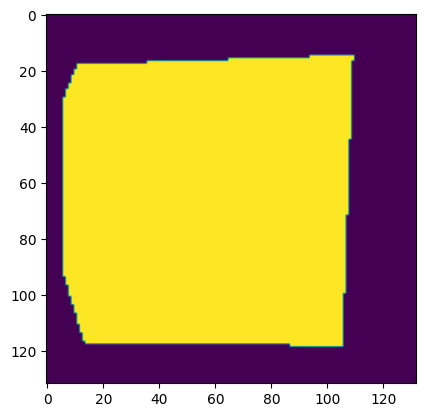

(132, 132) (37, 132, 132)
[(0, 217623, 52301), (4, 38877, 6568), (8, 3041, 42193), (3, 2374, 66155), (6, 1417, 43218), (7, 973, 36309), (2, 933, 9001), (9, 850, 28477), (1, 661, 30799), (5, 521, 24091), (12, 200, 12216), (13, 180, 7219), (11, 167, 13685), (10, 94, 3763), (14, 6, 776)]
HT448C1-Th1K1Fp1


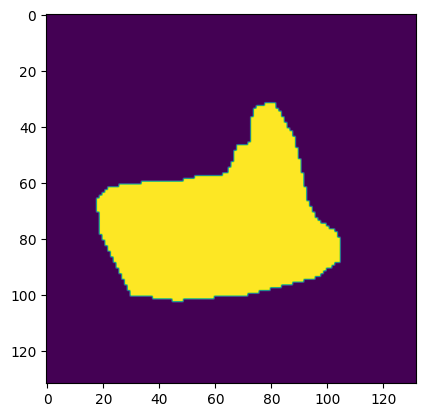

(132, 132) (14, 132, 132)
[(11, 181131, 10861), (4, 5284, 1282), (9, 3910, 13348), (1, 1352, 4106), (8, 486, 4448), (3, 481, 2282), (5, 443, 4649), (0, 247, 5970), (10, 210, 565), (12, 102, 256), (13, 52, 559), (7, 28, 1687), (2, 20, 125)]
HT413C1-Th1k4A1


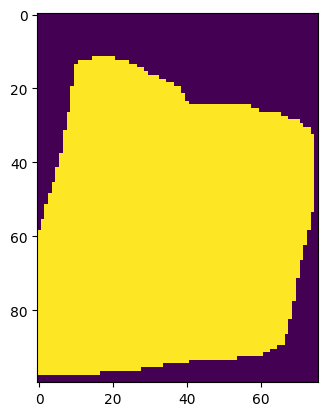

(100, 76) (42, 100, 76)
[(0, 90256, 63296), (16, 12516, 4286), (9, 2, 36142)]
HT553P1-H2


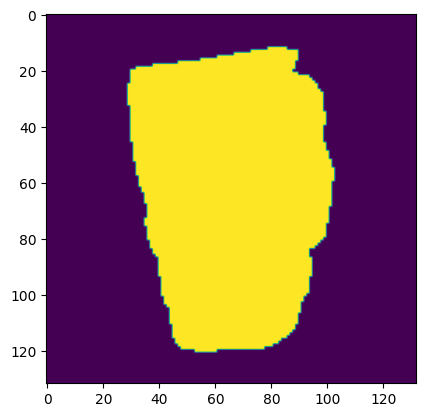

(132, 132) (2, 132, 132)
[(0, 22150, 2366), (1, 28, 0), (26, 2, 666)]
S18-9906


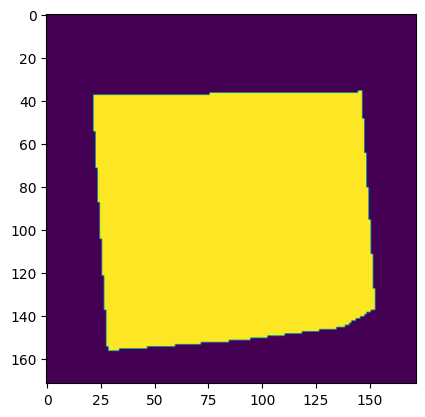

(172, 172) (33, 172, 172)
[(14, 204336, 9298), (7, 200739, 77023), (10, 40386, 52907), (3, 16908, 91570), (2, 11537, 58320), (1, 8004, 34029), (5, 7800, 52302), (13, 5147, 21593), (0, 4806, 32213), (6, 3087, 20358), (4, 1944, 16065), (12, 995, 1779), (8, 374, 853), (9, 237, 324), (11, 67, 236), (17, 37, 178), (19, 36, 234), (15, 20, 121), (18, 12, 157), (20, 6, 110), (16, 6, 118)]
S18-5591-C8


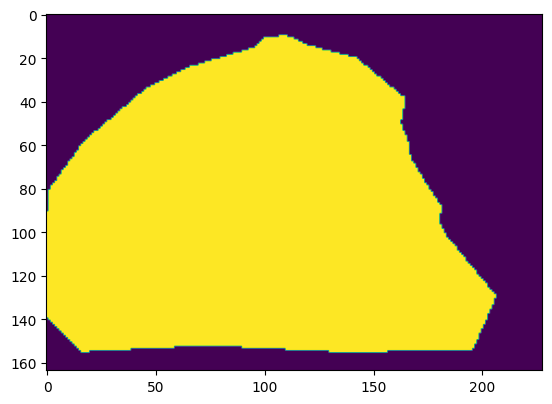

(164, 228) (24, 164, 228)
[(54, 325962, 81521), (31, 14754, 63980), (0, 9051, 121028), (30, 4948, 65577), (33, 593, 17453), (27, 550, 663), (9, 441, 76106), (26, 375, 1229), (11, 343, 561), (3, 218, 8052), (32, 180, 4), (1, 81, 22002), (25, 79, 2989), (34, 20, 31524), (4, 14, 14453), (7, 6, 2722), (10, 4, 118), (5, 3, 8502), (12, 2, 994)]


In [16]:
from collections import Counter
for case in case_order:
    print(case)
    v = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb'))['labeled']['integrated']
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = v.shape[1:]
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    plt.imshow(tissue_mask)
    plt.show()
    
    mask_counts = Counter(v[..., ~tissue_mask].flatten())
    other_counts = Counter(v[..., tissue_mask].flatten())
    
    print(tissue_mask.shape, v.shape)
    print([(c, val, other_counts[c]) for c, val in mask_counts.most_common()])
    
    


In [17]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [18]:
case_to_background = {
    'HT339B2-H1': [4, 3],
    'HT565B1-H2': [0],
    'HT268B1': [9],
    'HT397B1': [0],
    'HT206B1': [13],
    'C3L-01287': [4],
    'C3L-00982': [0],
    'C3L-02551': [3],
    'HT413C1-K2': [5],
    'HT225C1': [0],
    'HT448C1-Th1K1Fp1': [11],
    'HT413C1-Th1k4A1': [0, 16],
    'HT553P1-H2': [0],
    'S18-9906': [14],
    'S18-5591-C8': [54]
}

In [19]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/outputs.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/ou

In [23]:
# for case in case_order:
#     print(case)
#     config = yaml.safe_load(open(os.path.join(project_dir, case, 'mushroom_50res', 'config.yaml')))
#     config['trainer_kwargs']['pct_expression'] = None # make sure we get all visium genes
#     config['dtype_to_chkpt'] = None

#     mushroom = Mushroom.from_config(
#         config, accelerator='cpu'
#     )
#     mushroom.embed_sections()
    
    
    
#     to_true_pixels = {}
#     target_size = None
#     for dtype, spore in mushroom.dtype_to_spore.items():
#         target_size = spore.true_pixels[0].shape[:-1]
#         print(dtype, target_size, spore.true_pixels[0].shape)
#         to_true_pixels[dtype] = {
#             'channels': spore.learner_data.dtype_to_channels[dtype],
#             'true_pixels': spore.true_pixels
#         }
#     print(target_size)
    
#     pickle.dump(to_true_pixels,
#                 open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'wb'), protocol=4)
#     del(to_true_pixels)
    
    
#     to_true_pixels = {}
#     for dtype, spore in mushroom.dtype_to_spore.items():
#         sids = [x for x, _ in spore.section_ids]
#         to_img = spore.learner_data.dtype_to_section_to_img[dtype]
#         imgs = [to_img[sid] for sid in sids]
#         print(dtype, len(imgs), imgs[0].shape)
#         imgs = [utils.rescale(x, size=target_size, dim_order='c h w', target_dtype=x.dtype) for x in imgs]
#         print(dtype, len(imgs), imgs[0].shape)
#         imgs = [rearrange(x, 'c h w -> h w c').numpy() for x in imgs]
        
#         to_true_pixels[dtype] = {
#             'channels': spore.learner_data.dtype_to_channels[dtype],
#             'true_pixels': imgs
#         }
    
#     pickle.dump(to_true_pixels,
#                 open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels_raw.pkl'), 'wb'), protocol=4)

In [21]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/true_pixels_raw.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/true_pixels_raw.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/true_pixels_raw.pkl',


In [22]:
# spore = mushroom.dtype_to_spore['visium']

# to_img = spore.learner_data.dtype_to_section_to_img['visium']
# channels = spore.learner_data.dtype_to_channels['visium']
# img = next(iter(to_img.values()))
# img.shape

In [23]:
# im = img[channels.index('EPCAM')]
# plt.imshow(im)

In [86]:
dtype_to_true_pixels = pickle.load(
    open(os.path.join(project_dir, 'HT339B2-H1', 'mushroom_50res', 'true_pixels_raw.pkl'), 'rb')
)
channels, true_pixels = dtype_to_true_pixels['visium']['channels'], dtype_to_true_pixels['visium']['true_pixels']
true_pixels = np.stack(true_pixels)
true_pixels.shape

(1, 132, 132, 17943)

In [87]:
x = np.exp(true_pixels) - 1
x.shape

(1, 132, 132, 17943)

In [88]:
x.max()

19359.178

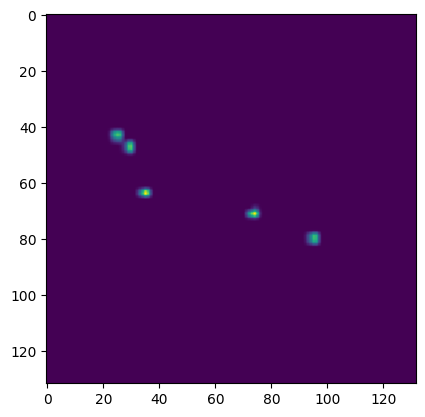

In [89]:
idx = channels.index('GZMK')
plt.imshow(true_pixels[0, ..., idx])

In [26]:
# (true_pixels.sum((0, -1)) + 1).shape
# true_pixels /= (true_pixels.sum((0, -1)) + 1)
# true_pixels.shape
# plt.imshow(true_pixels[0, idx])

In [28]:
case_to_exp = {}
for case in case_order:
    print(case)
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels_raw.pkl'), 'rb')
    )
    
    dtypes = [dt for dt in dtype_to_true_pixels.keys() if dt != 'integrated']
    dtype_to_exp = {}
    for dtype in dtypes:    
        channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
        true_pixels = np.stack(true_pixels)
        
#         # norm by grid count for visium and xenium
#         if dtype in ['visium', 'xenium', 'cosmx']:
#             true_pixels = rearrange(true_pixels, 'n h w c -> n c h w')
#             true_pixels /= (true_pixels.sum((0, 1)) + 1)
#             true_pixels = rearrange(true_pixels, 'n c h w -> n h w c')

        volume = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
        )['labeled']['integrated']

        outputs = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
        )
        section_ids = outputs['section_ids']
        section_positions = outputs['section_positions']
        positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if dt==dtype]
        volume = volume[positions]
        
        print(volume.shape, true_pixels.shape)
        data = []
        for label in np.unique(volume):
            data.append(true_pixels[volume==label].mean(0))
        exp_df = pd.DataFrame(data=data, columns=channels, index=np.unique(volume))
        dtype_to_exp[dtype] = exp_df
    
    case_to_exp[case] = dtype_to_exp
    
    

HT339B2-H1
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT565B1-H2
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT268B1
(4, 132, 132) (4, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 36601)
HT397B1
(6, 132, 132) (6, 132, 132, 3)
(2, 132, 132) (2, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 24)
(2, 132, 132) (2, 132, 132, 17943)
HT206B1
(3, 132, 124) (3, 132, 124, 3)
(6, 132, 124) (6, 132, 124, 36)
(6, 132, 124) (6, 132, 124, 377)
C3L-01287
(1, 220, 228) (1, 220, 228, 29)
(1, 220, 228) (1, 220, 228, 477)
C3L-00982
(1, 276, 196) (1, 276, 196, 3)
(3, 276, 196) (3, 276, 196, 32)
(1, 276, 196) (1, 276, 196, 477)
C3L-02551
(1, 148, 220) (1, 148, 220, 3)
(3, 148, 220) (3, 148, 220, 32)
(1, 148, 220) (1, 148, 220, 477)
HT413C1-K2
(1, 132, 132) (1, 132, 132, 3)
(1, 132, 132) (1, 132, 132, 33)
(1, 132, 132) (1, 132, 132, 17943)
HT225C1
(4, 132, 132) (4, 132, 132, 3)
(4, 132, 132) (4, 132, 132, 3660

In [29]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [34]:
masking_dtype_order = [
    'xenium',
    'multiplex',
    'visium',
]
dtype_to_mask_channel = {
    'multiplex': 'Pan-Cytokeratin',
    'xenium': 'EPCAM',
    'visium': 'EPCAM'
}

dtype_to_mask_channel_ccrcc = {
    'multiplex': ['CA9', 'LRP2'],
    'xenium': ['CA9', 'LRP2'],
    'visium': ['CA9', 'LRP2'],
}

case_to_thresh = {
    'HT339B2-H1': .75,
    'HT565B1-H2': .75,
    'HT268B1': .75,
    'HT397B1': .75,
    'HT206B1': .75,
    'C3L-01287': .75,
    'C3L-00982': .75,
    'C3L-02551': .75,
    'HT413C1-K2': .75,
    'HT225C1': .75,
    'HT448C1-Th1K1Fp1': .75,
    'HT413C1-Th1k4A1': .75,
    'HT553P1-H2': .75,
    'S18-9906': .75,
    'S18-5591-C8': .75
}

HT339B2-H1


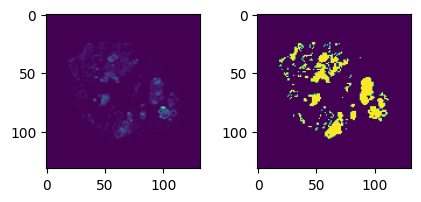

HT565B1-H2


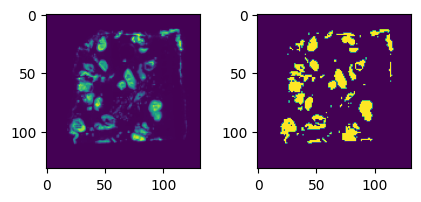

HT268B1


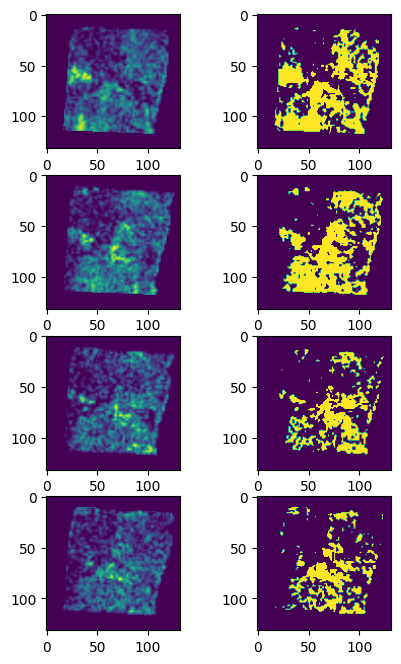

HT397B1


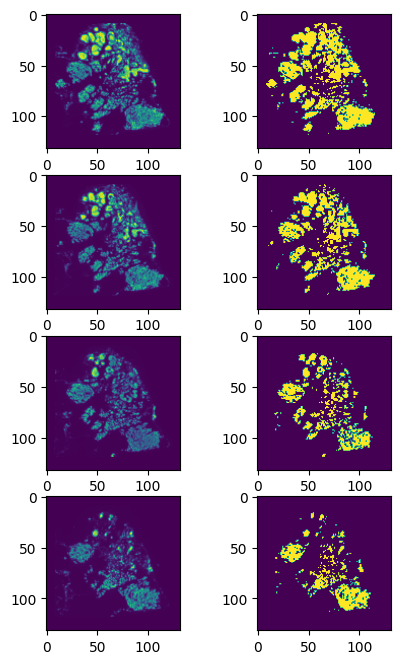

HT206B1


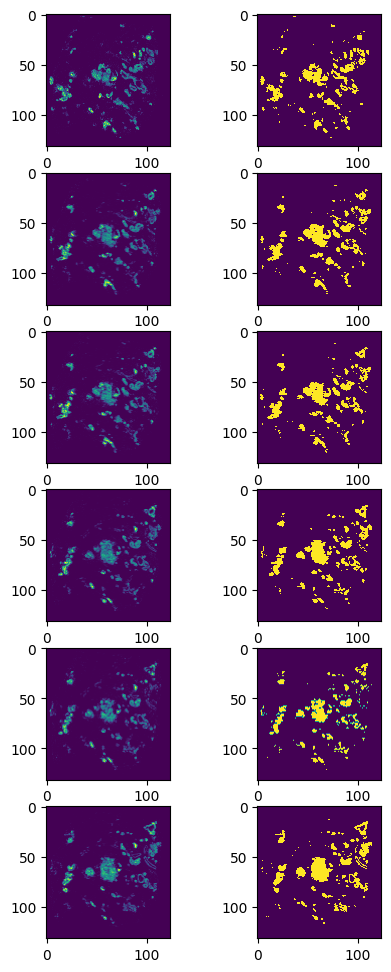

C3L-01287


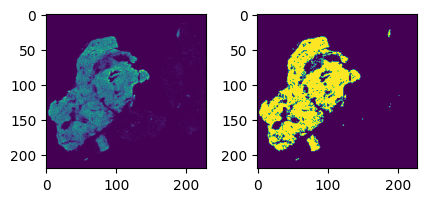

C3L-00982


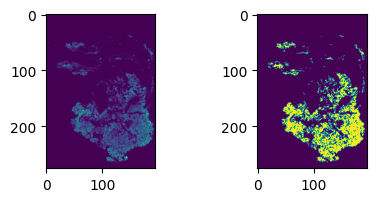

C3L-02551


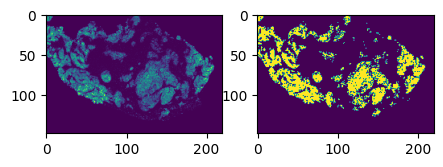

HT413C1-K2


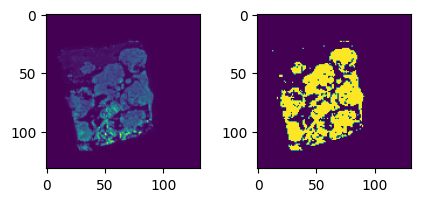

HT225C1


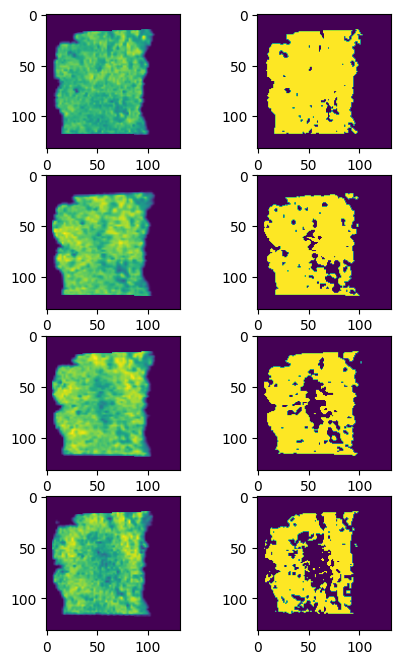

HT448C1-Th1K1Fp1


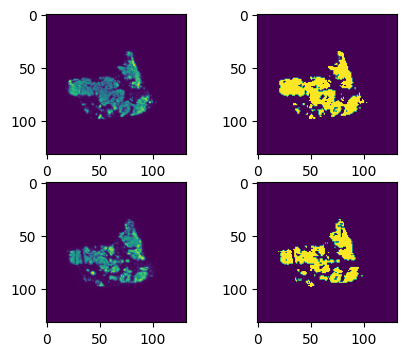

HT413C1-Th1k4A1


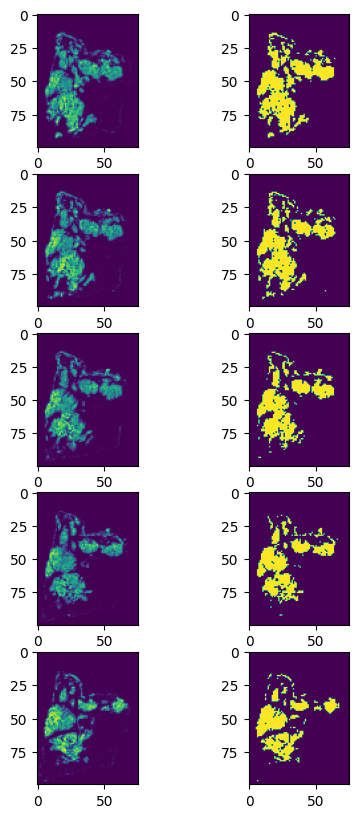

HT553P1-H2


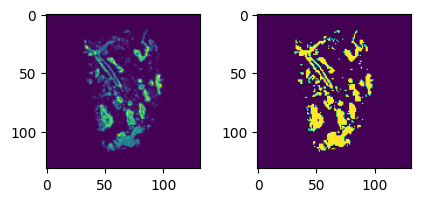

S18-9906


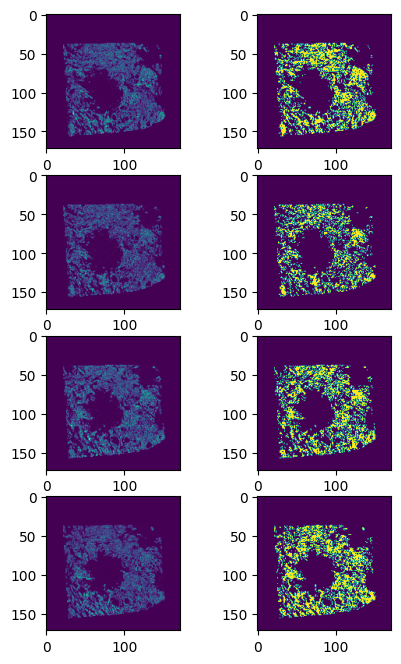

S18-5591-C8


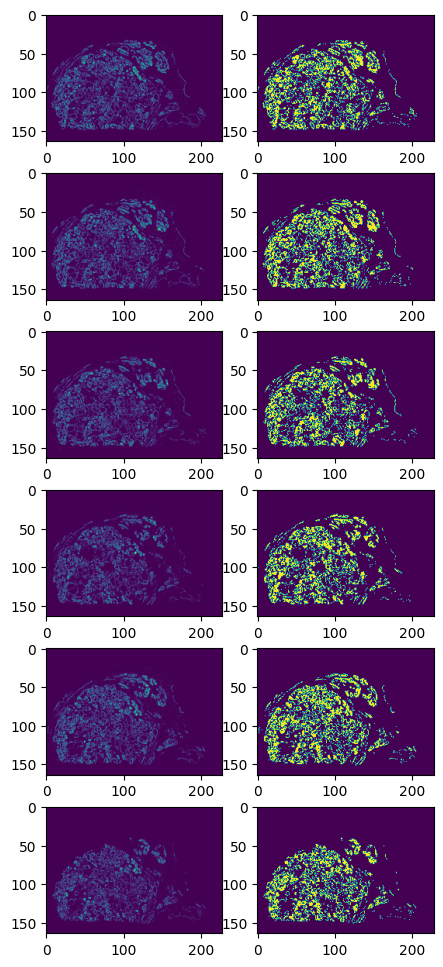

In [35]:
case_to_tumor_mask = {}
for case in case_order:
    print(case)
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    dtype = [dt for dt in masking_dtype_order if dt in dtype_to_true_pixels][0]
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = np.stack(true_pixels)
    
    if 'C3L' in case:
#         print()
        channel_idx = [channels.index(x) for x in dtype_to_mask_channel_ccrcc[dtype]]
    else:
        channel_idx = channels.index(dtype_to_mask_channel[dtype])
    
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = true_pixels.shape[1:-1]
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    
    thresh = case_to_thresh[case]
    
    nrows = len(true_pixels)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(5, nrows * 2))
    if nrows == 1:
        axs = rearrange(axs, 'n -> 1 n')

    for i, tp in enumerate(true_pixels):
        if isinstance(channel_idx, list):
            img = tp[..., channel_idx].mean(-1)
        else:
            img = tp[..., channel_idx]
        img[~tissue_mask] = img.min()
        axs[i, 0].imshow(img)
        axs[i, 1].imshow(img > thresh)
    plt.show()
    
    if isinstance(channel_idx, list):
        img = true_pixels[..., channel_idx].mean(-1)
    else:
        img = true_pixels[..., channel_idx]
    img[..., ~tissue_mask] = img.min()
    tumor_mask = img > thresh
    
    case_to_tumor_mask[case] = tumor_mask


    

In [36]:
outputs = pickle.load(
    open(os.path.join(project_dir, 'HT397B1', 'mushroom_50res', f'outputs.pkl'), 'rb')
)
outputs.keys()


dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [37]:
case_to_true_slice = {}
case_to_labeled_slice = {}
for case in case_order:
    print(case)
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    dtype = [dt for dt in masking_dtype_order if dt in dtype_to_true_pixels][0]
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = true_pixels[0]
    
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    labeled = volume[0]
    
    case_to_true_slice[case] = true_pixels
    case_to_labeled_slice[case] = labeled

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


In [38]:
def get_nbhd_rgb(case, nbhds):
    labeled = case_to_labeled_slice[case]
    rgb = vis_utils.display_labeled_as_rgb(labeled)
    
    m = np.zeros_like(labeled, dtype=bool)
    for l in nbhds:
        m |= labeled==l
    
    rgb[~m] = 0.
    
    return rgb

def get_intensity_img(case, dtype, gene):
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = true_pixels[0]
    
    img = true_pixels[..., channels.index(gene)]
    
    return img


In [39]:
case_to_contact_counts = {}
for case in case_order:
    print(case)
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    
    outputs = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
    )
    section_ids = outputs['section_ids']
    section_positions = outputs['section_positions']
    dtypes = sorted(set([v for _, v in section_ids]))
    
    dtype = [dt for dt in masking_dtype_order if dt in dtypes][0]
    positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if dt==dtype]
    volume = volume[positions]
    
    tumor_mask = case_to_tumor_mask[case]
    
    assert volume.shape[0] == tumor_mask.shape[0]
    
    data, labels = [], np.unique(volume)
    counts = Counter()
    for v, m in zip(volume, tumor_mask):
        expanded = skimage.morphology.binary_dilation(m)
        boundary = expanded ^ m
        counts += Counter(v[boundary])
    
    case_to_contact_counts[case] = counts

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


In [40]:
case_to_contact_counts['HT397B1']

Counter({14: 820,
         15: 790,
         7: 730,
         0: 688,
         5: 610,
         16: 509,
         6: 506,
         13: 465,
         3: 392,
         11: 278,
         12: 263,
         4: 163,
         9: 101,
         10: 69,
         8: 8,
         19: 8,
         1: 5,
         17: 4,
         18: 2,
         2: 1})

In [41]:
# case_to_specific = {}
# case_to_integrated = {}
# for case in case_order:
#     fp = os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl')
#     outputs = pickle.load(open(fp, 'rb'))
#     dtype_to_specific = outputs['dtype_to_cluster_intensities']['dtype_specific'][-1]
#     dtype_to_integrated = outputs['dtype_to_cluster_intensities']['integrated'][-1]

#     case_to_specific[case] = dtype_to_specific
#     case_to_integrated[case] = dtype_to_integrated                    

In [42]:
gene_sets = json.load(open(os.path.join(project_dir, 'analysis', 'gene_sets', 'c4.3ca.v2023.2.Hs.json')))
gene_sets.keys()

dict_keys(['GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_7_STRESS_IN_VITRO', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_8_PROTEASOMAL_DEGRADATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_9_UNFOLDED_PROTEIN_RESPONSE', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_18_INTERFERON_MHC_II_2', 'GAVISH_3CA_MALIGNANT_ME

In [43]:
# dtype_to_gene_order = {dtype: set() for dtype in dtype_to_integrated.keys()}
# for dtype, df in dtype_to_integrated.items():
#     dtype_to_gene_order[dtype].update(df.columns)
# dtype_to_gene_order = {k:sorted(v) for k, v in dtype_to_gene_order.items()}


dtype_to_gene_order = {}
for case in case_order:
    dtype_to_integrated = case_to_exp[case]
    for dtype, df in dtype_to_integrated.items():
        if dtype not in dtype_to_gene_order:
            dtype_to_gene_order[dtype] = set()
    dtype_to_gene_order[dtype].update(df.columns)
dtype_to_gene_order = {k:sorted(v) for k, v in dtype_to_gene_order.items()}


dtype_to_exp_df = {dt:None for dt in dtype_to_gene_order}
for case in case_order:
    dtype_to_integrated = case_to_exp[case]
#     dtype_to_integrated = case_to_integrated[case]
    for dtype, df in dtype_to_integrated.items():
        if dtype in dtype_to_gene_order:
            order = dtype_to_gene_order[dtype]
            missing = sorted(set(order) - set(df.columns))
            tail = pd.DataFrame(data=np.full((df.shape[0], len(missing)), df.values.min()))
            tail.columns = missing
            tail.index = df.index
            combined = pd.concat((df, tail), axis=1)
            combined = combined[order]
            combined.index = [(case, nbhd) for nbhd in df.index.to_list()]

            if dtype_to_exp_df[dtype] is None:
                dtype_to_exp_df[dtype] = combined
            else:
                dtype_to_exp_df[dtype] = pd.concat((dtype_to_exp_df[dtype], combined), axis=0)

In [44]:
quant_dtypes = ['xenium', 'visium', 'cosmx']

data = []
exp_data = []
for case in case_order:
    print(case)
#     dtype_to_integrated = case_to_integrated[case]
    dtype_to_integrated = case_to_exp[case]
    dtypes = [qdt for qdt in quant_dtypes if qdt in dtype_to_integrated]
    for quant_dtype in dtypes:
        df = dtype_to_integrated[quant_dtype]
        for name, gs in gene_sets.items():
            genes = [g for g in gs['geneSymbols'] if g in df.columns]
            if len(genes) >= 3:
                nbhd_scores = df[genes].values.mean(1)
                for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                    data.append([case, quant_dtype, name, nbhd, score])

score_df = pd.DataFrame(data, columns=['case', 'dtype', 'gene_set', 'nbhd', 'score'])
score_df


HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


,case,dtype,gene_set,nbhd,score
0,HT339B2-H1,visium,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,0,0.000116
1,HT339B2-H1,visium,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,1,0.000091
2,HT339B2-H1,visium,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,2,0.000067
3,HT339B2-H1,visium,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,3,0.000040
4,HT339B2-H1,visium,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,4,0.000009
...,...,...,...,...,...
49787,S18-5591-C8,xenium,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS,52,0.000321
49788,S18-5591-C8,xenium,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS,53,0.000404
49789,S18-5591-C8,xenium,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS,54,0.000198
49790,S18-5591-C8,xenium,GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS,55,0.000491


In [45]:
case_to_background

{'HT339B2-H1': [4, 3],
 'HT565B1-H2': [0],
 'HT268B1': [9],
 'HT397B1': [0],
 'HT206B1': [13],
 'C3L-01287': [4],
 'C3L-00982': [0],
 'C3L-02551': [3],
 'HT413C1-K2': [5],
 'HT225C1': [0],
 'HT448C1-Th1K1Fp1': [11],
 'HT413C1-Th1k4A1': [0, 16],
 'HT553P1-H2': [0],
 'S18-9906': [14],
 'S18-5591-C8': [54]}

In [46]:
df = score_df.copy()
df = df.pivot(columns='gene_set', index=['case', 'dtype', 'nbhd'])
df = df.reset_index()

df = df[[False if nbhd in case_to_background[case] else True for case, nbhd in zip(df['case'], df['nbhd'])]]

df.index = [(case, nbhd) for case, nbhd in zip(df['case'], df['nbhd'])]


df

case   dtype nbhd  \
gene_set                                 
(C3L-00982, 1)  C3L-00982  xenium    1   
(C3L-00982, 2)  C3L-00982  xenium    2   
(C3L-00982, 3)  C3L-00982  xenium    3   
(C3L-00982, 4)  C3L-00982  xenium    4   
(C3L-00982, 5)  C3L-00982  xenium    5   
...                   ...     ...  ...   
(S18-9906, 16)   S18-9906  xenium   16   
(S18-9906, 17)   S18-9906  xenium   17   
(S18-9906, 18)   S18-9906  xenium   18   
(S18-9906, 19)   S18-9906  xenium   19   
(S18-9906, 20)   S18-9906  xenium   20   

                                                                score  \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION   
(C3L-00982, 1)                                           0.003472       
(C3L-00982, 2)                                           0.008786       
(C3L-00982, 3)                                           0.002666       
(C3L-00982, 4)                                           0.001097       
(C3L-00982, 5)                                           0.007617       
...                                                           ...       
(S18-9906, 16)                                                NaN       
(S18-9906, 17)                                                NaN       
(S18-9906, 18)                                                NaN       
(S18-9906, 19)                                                NaN       
(S18-9906, 20)                                                NaN       

                                                                           \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION   
(C3L-00982, 1)                                                NaN           
(C3L-00982, 2)                                                NaN           
(C3L-00982, 3)                                                NaN           
(C3L-00982, 4)                                                NaN           
(C3L-00982, 5)                                                NaN           
...                                                           ...           
(S18-9906, 16)                                                NaN           
(S18-9906, 17)                                                NaN           
(S18-9906, 18)                                                NaN           
(S18-9906, 19)                                                NaN           
(S18-9906, 20)                                                NaN           

                                                          \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1   
(C3L-00982, 1)                                  0.016835   
(C3L-00982, 2)                                  0.012774   
(C3L-00982, 3)                                  0.021803   
(C3L-00982, 4)                                  0.023173   
(C3L-00982, 5)                                  0.013154   
...                                                  ...   
(S18-9906, 16)                                  0.003376   
(S18-9906, 17)                                  0.003141   
(S18-9906, 18)                                  0.002998   
(S18-9906, 19)                                  0.003670   
(S18-9906, 20)                                  0.004063   

                                                          \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2   
(C3L-00982, 1)                                  0.009024   
(C3L-00982, 2)                                  0.008530   
(C3L-00982, 3)                                  0.009516   
(C3L-00982, 4)                                  0.009751   
(C3L-00982, 5)                                  0.008472   
...                                                  ...   
(S18-9906, 16)                                  0.000747   
(S18-9906, 17)                                  0.000934   
(S18-9906, 18)                                  0.000794   
(S18-9906, 19)                                  0.000842   
(S18-9906, 20)       

In [47]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [48]:
# genes = [
#     'EPCAM',
#     'ACTA2',
#     'CD68',
#     'CD31',
#     'CD3D',
#     'CD8A',
#     'GZMK',
#     'GNLY',
#     'KLRB1',
#     'KLRD1',
#     'NCAM1',

# ]

In [49]:
components = {
    'Fibroblast': ['ACTA2', 'COL17A1', 'MYH11', 'CNN1'],
    'T cell': ['CD3D', 'CD3E', 'IL7R', 'CD2', 'CD247'],
    'NK cell': ['GZMK', 'GNLY', 'KLRB1', 'KLRD1', 'NCAM1'],
#     'B cell': ['MS4A1'],
    'Macrophage': ['CD68', 'CD163'],
    'Epithelial': ['EPCAM'],
    'Endothelial': ['PECAM1'],
#     'Epithelial - CCRCC': ['LRP2', 'CA9'],
}

In [50]:
def score_gene_set(df, gene_set):
    data = []
    order = sorted(gene_set.keys())
    for name in order:
        genes = gene_set[name]
        f = df[[c for c in df.columns if c in genes]]
        data.append(f.values.mean(1).flatten())
    scored = pd.DataFrame(data=data, columns=df.index, index=order).T
    return scored

In [51]:
scoring_order = ['xenium', 'visium']
case_to_scored = {}
for case in case_order:
#     dtype_to_integrated = case_to_integrated[case]
    dtype_to_integrated = case_to_exp[case]
    dtype = [dt for dt in scoring_order if dt in dtype_to_integrated][0]
    
    scored = score_gene_set(dtype_to_integrated[dtype], components)
    
    scored = scored[[True if x not in case_to_background[case] else False for x in scored.index]]
#     scored -= np.expand_dims(scored.min(1), -1)
#     scored /= np.expand_dims(scored.max(1), -1)
#     scored -= scored.min(1)
#     scored /= scored.max(1)
    
    
    case_to_scored[case] = scored
case_to_scored.keys()

dict_keys(['HT339B2-H1', 'HT565B1-H2', 'HT268B1', 'HT397B1', 'HT206B1', 'C3L-01287', 'C3L-00982', 'C3L-02551', 'HT413C1-K2', 'HT225C1', 'HT448C1-Th1K1Fp1', 'HT413C1-Th1k4A1', 'HT553P1-H2', 'S18-9906', 'S18-5591-C8'])

In [52]:
# del(mushroom)

In [53]:
# mushroom = Mushroom.from_config('/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res')

In [54]:
# config = yaml.safe_load(open('/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml'))
# config['trainer_kwargs']['pct_expression'] = None
# config['dtype_to_chkpt'] = None

# m2 = Mushroom.from_config(config)

In [55]:
# m2.embed_sections()

In [56]:
# for name, genes in components.items():
#     channels = m2.dtype_to_spore['visium'].dtype_to_channels['visium']
#     print(name, [g for g in genes if g in channels])

In [57]:
# m2.dtype_to_spore['visium'].true_pixels[0].shape

In [58]:
# spore = m2.dtype_to_spore['visium']

In [59]:
# spore.learner_data.dtype_to_channels['visium'].index('MS1A1')

In [60]:
# spore.learner_data.dtype_to_section_to_img

In [61]:
# gene_df

In [62]:
case_to_scored['HT339B2-H1']

,Endothelial,Epithelial,Fibroblast,Macrophage,NK cell,T cell
0,0.000091,0.000228,0.000146,0.000030,8.391663e-07,8.996748e-07
1,0.000135,0.000197,0.000244,0.000054,1.966880e-06,1.644900e-06
2,0.000218,0.000140,0.000351,0.000067,1.690064e-06,2.140224e-06
5,0.000066,0.000042,0.000085,0.000016,0.000000e+00,0.000000e+00
6,0.000160,0.000185,0.000262,0.000055,7.573759e-07,1.998539e-06
7,0.000169,0.000172,0.000274,0.000054,7.097557e-07,1.088790e-06
8,0.000268,0.000130,0.000370,0.000051,1.516143e-06,4.118810e-06
9,0.000205,0.000156,0.000321,0.000056,2.201309e-06,1.361845e-06
10,0.000168,0.000176,0.000295,0.000042,5.747462e-07,1.485068e-06
11,0.000163,0.000177,0.000269,0.000055,1.007897e-06,1.451261e-06


In [63]:
case_to_scored['HT206B1']

,Endothelial,Epithelial,Fibroblast,Macrophage,NK cell,T cell
0,0.002088,0.000988,0.004380,0.000829,0.000291,0.000849
1,0.001603,0.001541,0.000806,0.000646,0.000417,0.001348
2,0.000522,0.004805,0.000179,0.000390,0.000089,0.000165
3,0.001020,0.003863,0.000282,0.000696,0.000161,0.000360
4,0.001947,0.000255,0.000387,0.000431,0.001067,0.004441
5,0.002243,0.000773,0.003055,0.000896,0.000340,0.000929
6,0.002456,0.000357,0.000467,0.000996,0.000889,0.002903
7,0.000598,0.002550,0.000323,0.000439,0.000228,0.000333
8,0.002030,0.000878,0.000455,0.001013,0.000431,0.001168
9,0.002110,0.000804,0.000448,0.001049,0.000466,0.001326


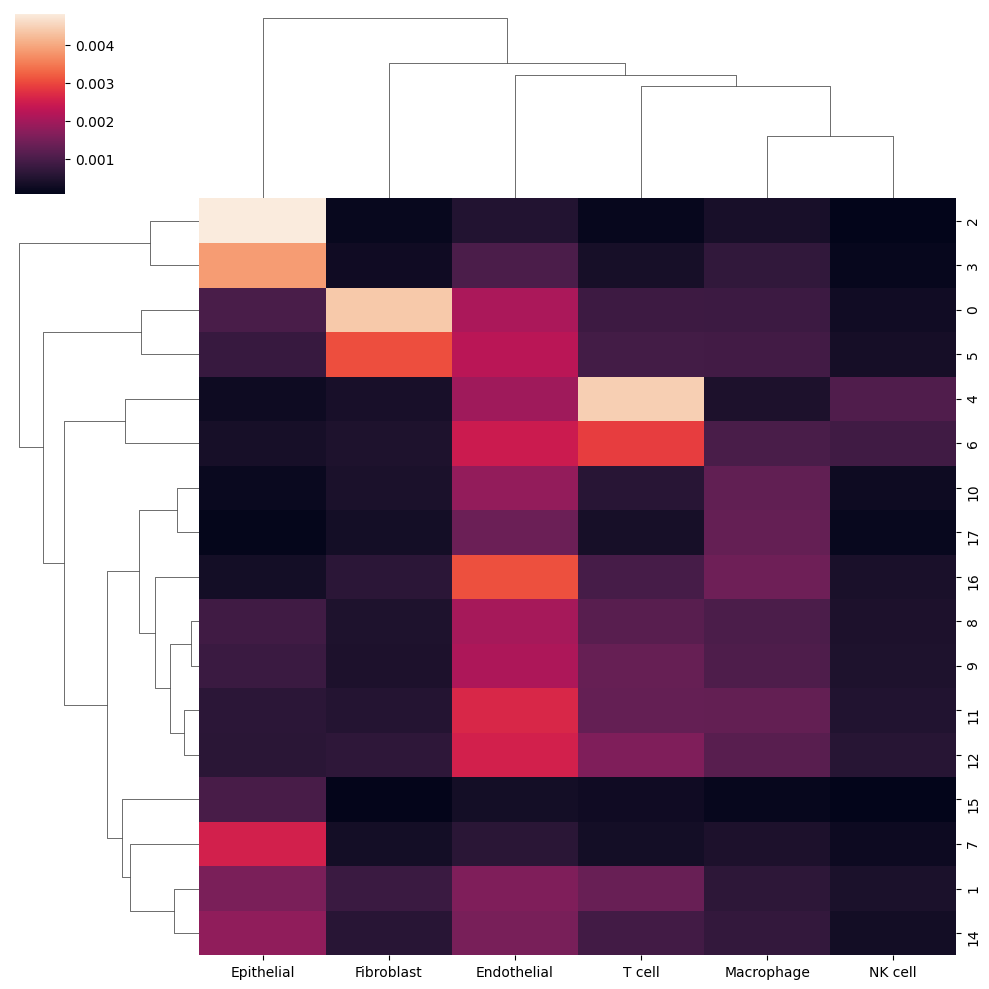

In [65]:
sns.clustermap(case_to_scored['HT206B1'], col_cluster=True, row_cluster=True)
plt.show()

In [68]:
cases = []
dtypes = []
combined = None
for case, scored in case_to_scored.items():
    cases += [case] * len(scored)

    dtype_to_integrated = case_to_exp[case]
    dtype = [dt for dt in scoring_order if dt in dtype_to_integrated][0]
    dtypes += [dtype] * len(scored)

    if combined is None:
        combined = scored.copy()
    else:
        combined = pd.concat((combined, scored), axis=0)
#     combined[combined>3.5] = 3.5
combined

,Endothelial,Epithelial,Fibroblast,Macrophage,NK cell,T cell
0,0.000091,0.000228,0.000146,0.000030,8.391663e-07,8.996748e-07
1,0.000135,0.000197,0.000244,0.000054,1.966880e-06,1.644900e-06
2,0.000218,0.000140,0.000351,0.000067,1.690064e-06,2.140224e-06
5,0.000066,0.000042,0.000085,0.000016,0.000000e+00,0.000000e+00
6,0.000160,0.000185,0.000262,0.000055,7.573759e-07,1.998539e-06
...,...,...,...,...,...,...
51,0.000444,0.000446,0.003542,0.000130,1.935616e-04,2.442968e-04
52,0.000506,0.001450,0.001416,0.000091,8.191690e-05,7.954930e-05
53,0.000551,0.001013,0.002277,0.000100,1.302923e-04,1.401587e-04
55,0.000488,0.001334,0.002483,0.000114,1.301585e-04,1.296285e-04


In [69]:
len(dtypes)

317

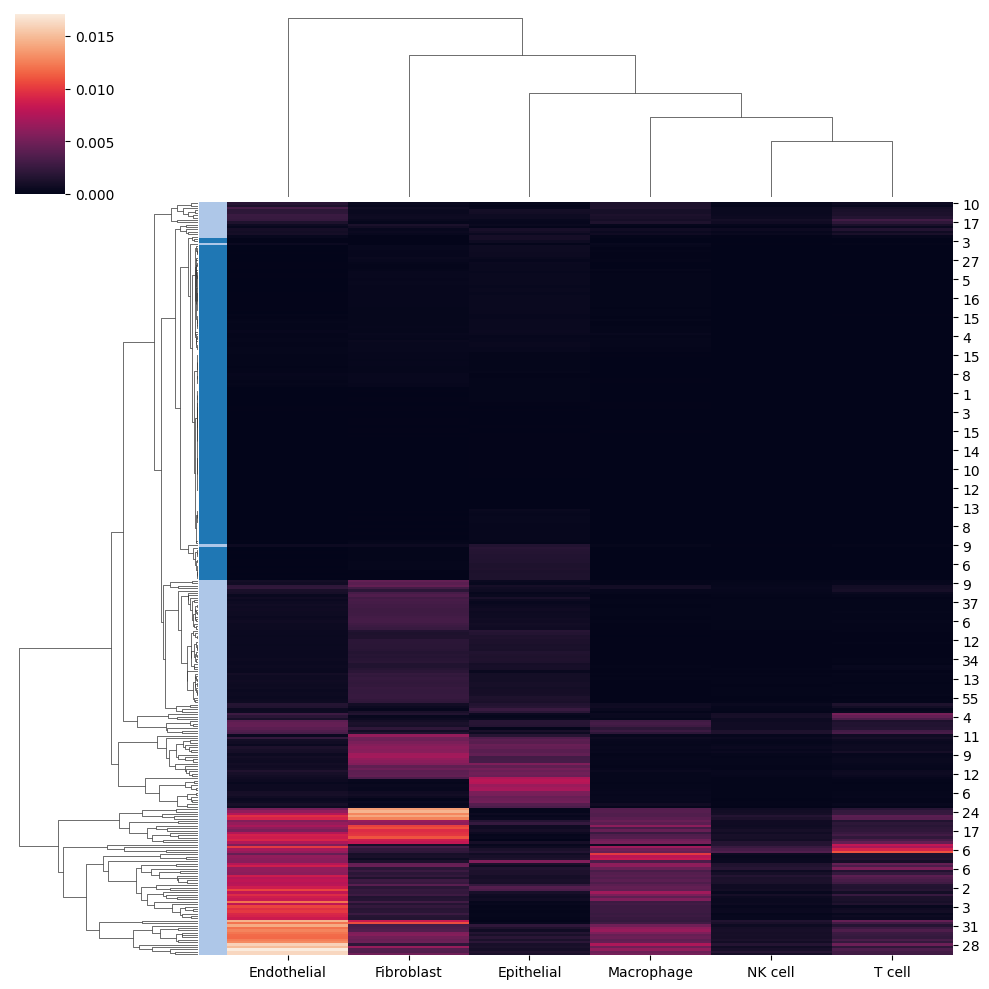

In [70]:
# colors = [sns.color_palette('tab20')[case_order.index(z)] for z in cases]
order = ['visium', 'xenium']
colors = [sns.color_palette('tab20')[order.index(z)] for z in dtypes]
sns.clustermap(combined, col_cluster=True, row_cluster=True, row_colors=colors)
plt.show()

In [71]:
# sns.distplot(combined['NK cell'])

In [72]:
cuts = [.75, .9, .95]
dtype_to_cuts = {dt:{} for dt in set(dtypes)}
for dt in set(dtypes):
    ct_to_exp_cut = {}
    for c in combined.columns:
        f = combined[np.asarray(dtypes)==dt]
        ct_to_exp_cut[c] = {}
        for cut in cuts:
            val = f.sort_values(c)[c].to_list()[int(cut * f.shape[0])]
            ct_to_exp_cut[c][cut] = val
    dtype_to_cuts[dt] = ct_to_exp_cut
print(dtype_to_cuts)

{'xenium': {'Endothelial': {0.75: 0.00765555864199996, 0.9: 0.010434889234602451, 0.95: 0.01267779991030693}, 'Epithelial': {0.75: 0.0017658440629020333, 0.9: 0.004553215578198433, 0.95: 0.005293074995279312}, 'Fibroblast': {0.75: 0.004222203977406025, 0.9: 0.0065337857231497765, 0.95: 0.010295574553310871}, 'Macrophage': {0.75: 0.003639550879597664, 0.9: 0.004978755488991737, 0.95: 0.0061095841228961945}, 'NK cell': {0.75: 0.0007744275499135256, 0.9: 0.001230867812409997, 0.95: 0.0016317472327500582}, 'T cell': {0.75: 0.002122889505699277, 0.9: 0.0034319888800382614, 0.95: 0.004433219321072102}}, 'visium': {'Endothelial': {0.75: 9.251409937860444e-05, 0.9: 0.00017745429067872465, 0.95: 0.0002177497954107821}, 'Epithelial': {0.75: 0.00043520721374079585, 0.9: 0.0009401481947861612, 0.95: 0.0014013423351570964}, 'Fibroblast': {0.75: 0.00027997608412988484, 0.9: 0.00034245289862155914, 0.95: 0.0003719987580552697}, 'Macrophage': {0.75: 0.00012848898768424988, 0.9: 0.0001637979003135115, 

In [73]:
# # # exp_thresh = .5
# # exp_quartile = .75
# contact_thres = .05

In [74]:
# case = 'HT413C1-Th1k4A1'
# counts = case_to_contact_counts[case]
# scored = case_to_scored[case]

# total = sum(counts.values())
# fracs = {k:v / total for k, v in counts.items()}

# nbhds, contact_fracs = zip(*sorted([(nbhd, frac) for nbhd, frac in fracs.items()
#                            if frac > contact_thres
#                            if nbhd in scored.index],
#                           key=lambda x:-x[1]))
# nbhds, contact_fracs


# # scored

In [75]:
# exp = scored.loc[list(nbhds)].copy()

# expanded = exp.copy()
# for cut in cuts:
#     vals = np.asarray([ct_to_exp_cut[c][cut] for c in exp.columns])
#     m = exp > vals
#     m.columns = [f'{c}_q{cut}' for c in m]
#     expanded = pd.concat((expanded, m), axis=1)
# expanded['case'] = case
# expanded['tissue_type'] = case_to_disease[case]
# expanded['contact_frac'] = contact_fracs

# expanded

In [76]:
case_to_sections

{'C3L-00982': [{'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s0_C3L-00982-U1_multiplex.ome.tiff'}],
   'position': 0,
   'sid': 'C3L-00982-U1'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s1_C3L-00982-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'C3L-00982-U2'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s2_C3L-00982-U4_multiplex.ome.tiff'}],
   'position': 15,
   'sid': 'C3L-00982-U4'},
  {'data': [{'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s3_C3L-00982-U5_he.tif'}],
   'position': 20,
   'sid': 'C3L-00982-U5'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s4_C3L-00982-U7_multiplex.ome.tiff'}],
   'position':

In [77]:
contact_thres = .02

agg = []
for case in case_order:
    counts = case_to_contact_counts[case]
    scored = case_to_scored[case]
    
    dtypes = [mapping['dtype'] for entry in case_to_sections[case] for mapping in entry['data']]
    dtype = [dt for dt in scoring_order if dt in dtypes][0]

    total = sum(counts.values())
    fracs = {k:v / total for k, v in counts.items()}

    nbhds, contact_fracs = zip(*sorted([(nbhd, frac) for nbhd, frac in fracs.items()
                               if frac > contact_thres
                               if nbhd in scored.index],
                              key=lambda x:-x[1]))
    
    exp = scored.loc[list(nbhds)].copy()

    expanded = exp.copy()
    for cut in cuts:
        vals = np.asarray([dtype_to_cuts[dtype][c][cut] for c in exp.columns])
        m = exp > vals
        m.columns = [f'{c}_q{cut}' for c in m]
        expanded = pd.concat((expanded, m), axis=1)
    expanded['case'] = case
    expanded['tissue_type'] = case_to_disease[case]
    expanded['contact_frac'] = contact_fracs
    expanded['nbhd'] = [f'nbhd {x}' for x in exp.index.to_list()]
    agg.append(expanded)
agg = pd.concat(agg, axis=0)
agg['range'] = [f'item{x}' for x in np.arange(agg.shape[0])]
agg
    

,Endothelial,Epithelial,Fibroblast,Macrophage,NK cell,T cell,Endothelial_q0.75,Epithelial_q0.75,Fibroblast_q0.75,Macrophage_q0.75,...,Epithelial_q0.95,Fibroblast_q0.95,Macrophage_q0.95,NK cell_q0.95,T cell_q0.95,case,tissue_type,contact_frac,nbhd,range
0,0.000091,0.000228,0.000146,0.000030,8.391663e-07,8.996748e-07,False,False,False,False,...,False,False,False,False,False,HT339B2-H1,BRCA,0.207294,nbhd 0,item0
2,0.000218,0.000140,0.000351,0.000067,1.690064e-06,2.140224e-06,True,False,True,False,...,False,False,False,False,False,HT339B2-H1,BRCA,0.150672,nbhd 2,item1
11,0.000163,0.000177,0.000269,0.000055,1.007897e-06,1.451261e-06,True,False,False,False,...,False,False,False,False,False,HT339B2-H1,BRCA,0.144914,nbhd 11,item2
14,0.000187,0.000163,0.000307,0.000057,1.133326e-06,1.286888e-06,True,False,True,False,...,False,False,False,False,False,HT339B2-H1,BRCA,0.110365,nbhd 14,item3
13,0.000142,0.000206,0.000232,0.000045,1.286967e-06,1.496563e-06,True,False,False,False,...,False,False,False,False,False,HT339B2-H1,BRCA,0.103647,nbhd 13,item4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0.000575,0.001436,0.001848,0.000114,1.248938e-04,1.944924e-04,False,False,False,False,...,False,False,False,False,False,S18-5591-C8,PKD,0.055871,nbhd 34,item119
1,0.001024,0.000304,0.003184,0.000214,2.153927e-04,4.461040e-04,False,False,False,False,...,False,False,False,False,False,S18-5591-C8,PKD,0.051652,nbhd 1,item120
33,0.000516,0.001040,0.001753,0.000117,1.339697e-04,3.047788e-04,False,False,False,False,...,False,False,False,False,False,S18-5591-C8,PKD,0.037965,nbhd 33,item121
5,0.000810,0.000932,0.002394,0.000150,1.481367e-04,2.581453e-04,False,False,False,False,...,False,False,False,False,False,S18-5591-C8,PKD,0.034172,nbhd 5,item122


In [78]:
nbhd_mapping = {}
r_nbhd_mapping = {}
current_idx = -1
current_case = agg['case'].to_list()[0]
current_pct = 0.

nbhds = []
starts, stops = [], []
for case, nbhd, frac in zip(agg['case'], agg['nbhd'], agg['contact_frac']):
    if case == current_case:
        current_idx += 1
    else:
        current_idx = 0
        current_case = case
        current_pct = 0.
    
    start = current_pct
    stop = start + frac
    current_pct = stop
    
    starts.append(start)
    stops.append(stop)
    
    nbhd_str = f'nbhd {current_idx}'
    nbhds.append(nbhd_str)
    
    if case not in nbhd_mapping:
        nbhd_mapping[case] = {}
    nbhd_mapping[case][nbhd] = nbhd_str
r_nbhd_mapping = {case:{v:k for k, v in mapping.items()} for case, mapping in nbhd_mapping.items()}
    
agg['renamed_nbhd'] = nbhds
agg['start'] = starts
agg['stop'] = stops
agg

,Endothelial,Epithelial,Fibroblast,Macrophage,NK cell,T cell,Endothelial_q0.75,Epithelial_q0.75,Fibroblast_q0.75,Macrophage_q0.75,...,NK cell_q0.95,T cell_q0.95,case,tissue_type,contact_frac,nbhd,range,renamed_nbhd,start,stop
0,0.000091,0.000228,0.000146,0.000030,8.391663e-07,8.996748e-07,False,False,False,False,...,False,False,HT339B2-H1,BRCA,0.207294,nbhd 0,item0,nbhd 0,0.000000,0.207294
2,0.000218,0.000140,0.000351,0.000067,1.690064e-06,2.140224e-06,True,False,True,False,...,False,False,HT339B2-H1,BRCA,0.150672,nbhd 2,item1,nbhd 1,0.207294,0.357965
11,0.000163,0.000177,0.000269,0.000055,1.007897e-06,1.451261e-06,True,False,False,False,...,False,False,HT339B2-H1,BRCA,0.144914,nbhd 11,item2,nbhd 2,0.357965,0.502879
14,0.000187,0.000163,0.000307,0.000057,1.133326e-06,1.286888e-06,True,False,True,False,...,False,False,HT339B2-H1,BRCA,0.110365,nbhd 14,item3,nbhd 3,0.502879,0.613244
13,0.000142,0.000206,0.000232,0.000045,1.286967e-06,1.496563e-06,True,False,False,False,...,False,False,HT339B2-H1,BRCA,0.103647,nbhd 13,item4,nbhd 4,0.613244,0.716891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,0.000575,0.001436,0.001848,0.000114,1.248938e-04,1.944924e-04,False,False,False,False,...,False,False,S18-5591-C8,PKD,0.055871,nbhd 34,item119,nbhd 4,0.613426,0.669297
1,0.001024,0.000304,0.003184,0.000214,2.153927e-04,4.461040e-04,False,False,False,False,...,False,False,S18-5591-C8,PKD,0.051652,nbhd 1,item120,nbhd 5,0.669297,0.720949
33,0.000516,0.001040,0.001753,0.000117,1.339697e-04,3.047788e-04,False,False,False,False,...,False,False,S18-5591-C8,PKD,0.037965,nbhd 33,item121,nbhd 6,0.720949,0.758915
5,0.000810,0.000932,0.002394,0.000150,1.481367e-04,2.581453e-04,False,False,False,False,...,False,False,S18-5591-C8,PKD,0.034172,nbhd 5,item122,nbhd 7,0.758915,0.793087


In [79]:
renamed_nbhd_order = [f'{x} {y}' for x, y in sorted(
    [x.split(' ') for x in set(agg['renamed_nbhd'])], key=lambda x:int(x[1]))]
renamed_nbhd_order

['nbhd 0',
 'nbhd 1',
 'nbhd 2',
 'nbhd 3',
 'nbhd 4',
 'nbhd 5',
 'nbhd 6',
 'nbhd 7',
 'nbhd 8',
 'nbhd 9',
 'nbhd 10',
 'nbhd 11',
 'nbhd 12',
 'nbhd 13',
 'nbhd 14']

In [81]:
import altair as alt

In [82]:
cols = ['case', 'tissue_type', 'renamed_nbhd', 'start', 'stop']
source = agg[cols]

c1 = alt.Chart(source).mark_bar().encode(
    x=alt.X("start"),
    x2=alt.X2("stop"),
    color=alt.Color('renamed_nbhd', sort=renamed_nbhd_order).scale(scheme="category20"),
    column=alt.Column('case', sort=case_order, )
)
c1

alt.Chart(...)

In [83]:
case_to_total_contact = {i:row['contact_frac']
                   for i, row in agg[['case', 'contact_frac']].groupby('case').sum().iterrows()}
case_to_total_contact

{'C3L-00982': 0.6569154656915466,
 'C3L-01287': 0.6653042688465032,
 'C3L-02551': 0.8704250295159386,
 'HT206B1': 0.8724751281278263,
 'HT225C1': 0.9636316739747227,
 'HT268B1': 0.9745425616547335,
 'HT339B2-H1': 0.8282149712092131,
 'HT397B1': 0.8618215845290081,
 'HT413C1-K2': 0.7766903914590747,
 'HT413C1-Th1k4A1': 0.7907634307257304,
 'HT448C1-Th1K1Fp1': 0.780388978930308,
 'HT553P1-H2': 0.8305785123966942,
 'HT565B1-H2': 0.6666666666666666,
 'S18-5591-C8': 0.8210069497132105,
 'S18-9906': 0.944487235915493}

In [84]:
tail = agg[['case', 'contact_frac']].groupby('case').sum()
for c in cols:
    if c not in tail.columns:
        tail[c] = np.nan
tail['case'] = tail.index.to_list()
tail['tissue_type'] = [case_to_disease[case] for case in tail['case']]

c2 = alt.Chart(tail).mark_bar().encode(
    alt.X("contact_frac"),
    color=alt.Color('tissue_type').scale(scheme="set2"),
    column=alt.Column('case', sort=case_order)
)

c2

alt.Chart(...)

In [85]:
# for cut in cuts:
cut = cuts[0]

domain = [True, False]
colors = ['seagreen', 'firebrick']

quart_cols = [c for c in agg.columns if str(cut) in c]
idx_cols = ['case', 'renamed_nbhd', 'start', 'stop']
cols = quart_cols + idx_cols

source = agg[cols]
source = source.melt(id_vars=idx_cols, value_vars=quart_cols)
source['start'] += .005
source['stop'] -= .005

c1 = alt.Chart(source).mark_bar().encode(
    x=alt.X("start"),
    x2=alt.X2("stop"),
    y=alt.Y('variable'),
#     color=alt.Color('renamed_nbhd').scale(scheme="category10"),
    color=alt.Color('value').scale(domain=domain, range=colors),
    column=alt.Column('case', sort=case_order, )
)
c1

alt.Chart(...)

In [376]:
color_map = {
    .75: ['seagreen', 'white'],
    .90: ['seagreen', 'white'],
    .95: ['seagreen', 'white'],
}
domain = [True, False]
cs = []
for cut in cuts:
    quart_cols = [c for c in agg.columns if str(cut) == c.split('_q')[-1]]
    idx_cols = ['case', 'renamed_nbhd', 'start', 'stop']
    cols = quart_cols + idx_cols

    source = agg[cols]
    source = source.melt(id_vars=idx_cols, value_vars=quart_cols)
    source['start'] += .005
    source['stop'] -= .005

    cs.append(alt.Chart(source).mark_bar().encode(
        x=alt.X("start"),
        x2=alt.X2("stop"),
        y=alt.Y('variable'),
    #     color=alt.Color('renamed_nbhd').scale(scheme="category10"),
        color=alt.Color('value').scale(domain=domain, range=color_map[cut]),
        column=alt.Column('case', sort=case_order, )
    ))
cs[0]

alt.Chart(...)

In [377]:
cs[1]

alt.Chart(...)

In [378]:
cs[2]

alt.Chart(...)

In [329]:
# case = 'S18-5591-C8'
# case = 'S18-9906'
case = 'HT339B2-H1'
# case = 'HT448C1-Th1K1Fp1'
# case = 'HT225C1'
# case = 'HT553P1-H2'

In [330]:
case_to_scored[case]

,Endothelial,Epithelial,Fibroblast,Macrophage,NK cell,T cell
0,1.250234,2.794176,1.329241,0.848821,0.226307,0.160094
1,1.054881,1.003202,1.273967,1.073722,0.325184,0.217080
2,0.519493,-0.053913,0.361619,0.397161,0.109750,0.111491
5,-0.017479,-0.324002,-0.265156,-0.288568,-0.074967,-0.075007
6,1.356802,0.998118,1.367709,0.957321,0.114440,0.288783
7,1.382507,0.836168,1.341792,1.103491,0.058357,0.122278
8,1.419700,0.160982,1.062436,0.401001,0.069898,0.302462
9,1.118713,0.429920,0.995155,0.740463,0.183882,0.049972
10,1.027349,0.776899,0.904685,0.524319,0.088540,0.207825
11,1.396897,0.933524,1.412304,1.093386,0.141916,0.228193


In [331]:
case_to_contact_counts[case]

Counter({0: 267,
         2: 95,
         1: 86,
         11: 80,
         13: 79,
         14: 53,
         4: 42,
         12: 15,
         6: 14,
         7: 12,
         16: 7,
         17: 5,
         8: 4,
         9: 3,
         18: 1})

In [277]:
sum(case_to_contact_counts[case].values())

17196

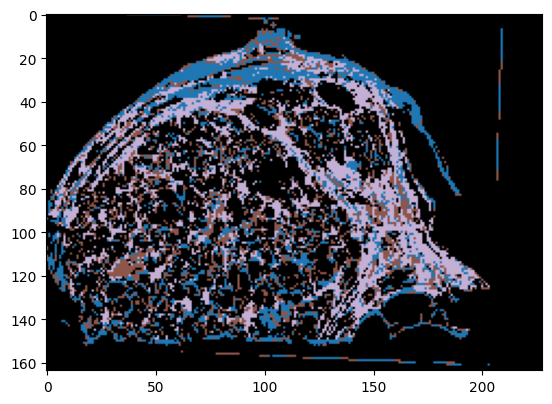

In [310]:
rgb = get_nbhd_rgb(case, [0, 9, 30])
plt.imshow(rgb)
plt.show()

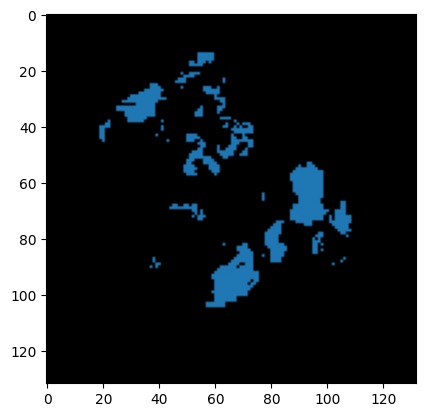

In [332]:
rgb = get_nbhd_rgb(case, [0])
plt.imshow(rgb)
plt.show()

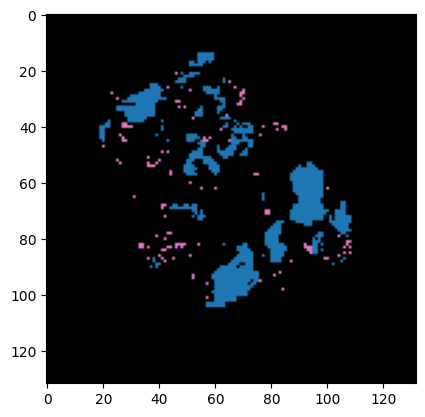

In [333]:
rgb = get_nbhd_rgb(case, [0, 12])
plt.imshow(rgb)
plt.show()

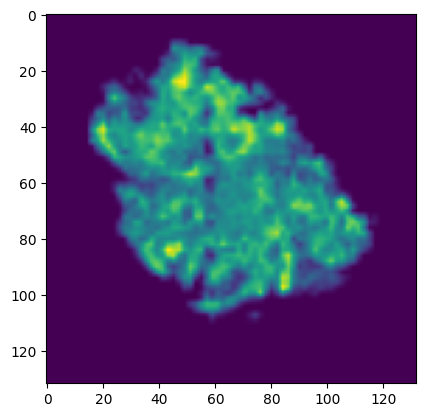

In [334]:
img = get_intensity_img(case, 'visium', 'ACTA2')
plt.imshow(img)
plt.show()

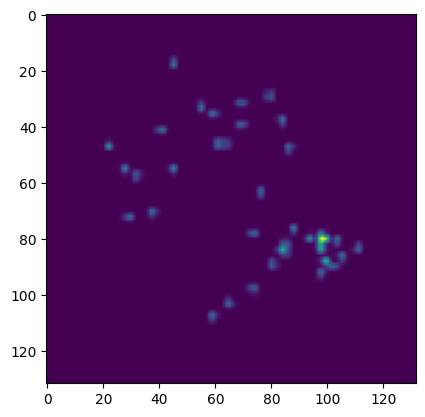

In [335]:
img = get_intensity_img(case, 'visium', 'IL7R')
plt.imshow(img)
plt.show()

In [338]:
components

{'Fibroblast': ['ACTA2', 'COL17A1', 'MYH11', 'CNN1'],
 'T cell': ['CD3D', 'CD3E', 'IL7R', 'CD2', 'CD247'],
 'NK cell': ['GZMK', 'GNLY', 'KLRB1', 'KLRD1', 'NCAM1'],
 'Macrophage': ['CD68', 'CD163'],
 'Epithelial': ['EPCAM'],
 'Endothelial': ['PECAM1']}

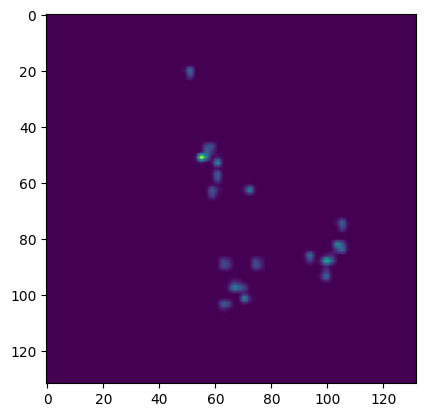

In [342]:
img = get_intensity_img(case, 'visium', 'NCAM1')
plt.imshow(img)
plt.show()

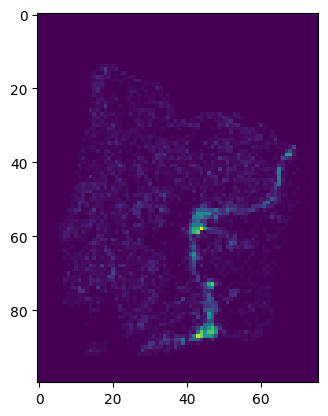

In [111]:
img = get_intensity_img(case, 'xenium', 'IL7R')
plt.imshow(img)
plt.show()

In [ ]:
cols = ['Epithelial', 'Macrophage', 'T cell', 'NK cell', 'Endothelial', 'Fibroblast']
idx = [2, 3,
      6, 12, 9, 11, 4, 5]

In [722]:
# cg = sns.clustermap(case_to_scored['HT339B2-H1'],
#                            standard_scale=0, col_cluster=False)
# plt.show()
# cg
# # plt.savefig('/data/estorrs/sandbox/xenium_heatmap_gs.svg')

In [717]:
case = 'HT206B1'
# # gene_df = case_to_integrated[case]['xenium']
# gene_df = case_to_integrated[case]['visium']
# gs_df = df[df['case']==case]
# gene_df = gene_df[[True if x not in case_to_background[case] else False
#                    for x in gene_df.index]]
# ct_df = score_gene_set(gene_df, components)

# to_macro = {
    
# }




In [647]:
# cg = sns.clustermap(gene_df[[g for g in genes if g in gene_df.columns]],
#                            standard_scale=0, col_cluster=False)
# plt.show()
# cg
# # plt.savefig('/data/estorrs/sandbox/xenium_heatmap_gs.svg')

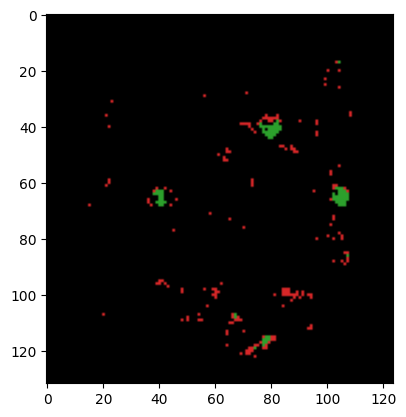

In [724]:
rgb = get_nbhd_rgb(case, [4, 6])
plt.imshow(rgb)
plt.show()

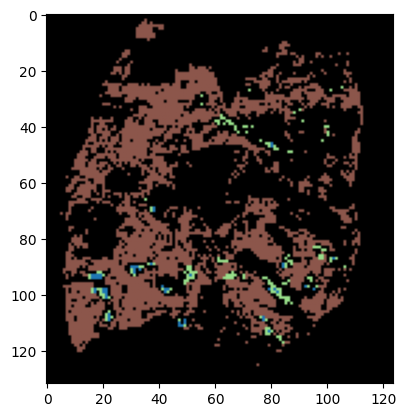

In [504]:
rgb = get_nbhd_rgb(case, [10, 0, 5])
plt.imshow(rgb)
plt.show()